#CMPE 258 HW3 - Part C2
Pure tensorflow to build neural network of 3d input, 2d output with auto differentiation

Abhishek Bais

In [9]:
# Import packages
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error

# Generate 3d input, 2d output

In [10]:
# Generate 3-d input, 2d output
n = 100
d = 3
x = tf.random.uniform((n, d), -1, 1)

# y = 5x^2 + wx + b
weights_true = tf.constant([[3., 2., -1.], [2., 3., 1.]])
bias_true = tf.constant([[0.5], [0.5]])
print(x.shape, weights_true.shape, bias_true.shape)

y_true = tf.matmul((5 * x ** 2), weights_true, transpose_b=True) + tf.matmul(x, weights_true, transpose_b=True) + tf.transpose(bias_true)
print(f'x: {x.shape}, weights: {weights_true.shape}, bias: {bias_true.shape}, y: {y_true.shape}')

print('x is: ' + str(x[:2]))
print('y is: ' + str(y_true[:2]))

(100, 3) (2, 3) (2, 1)
x: (100, 3), weights: (2, 3), bias: (2, 1), y: (100, 2)
x is: tf.Tensor(
[[-0.6832588  -0.5445142   0.20430899]
 [ 0.2573018   0.19876528 -0.7151408 ]], shape=(2, 3), dtype=float32)
y is: tf.Tensor(
[[6.9157705 7.0288205]
 [1.2155845 4.707547 ]], shape=(2, 2), dtype=float32)


# Generate a 3d TSNE plot of the data

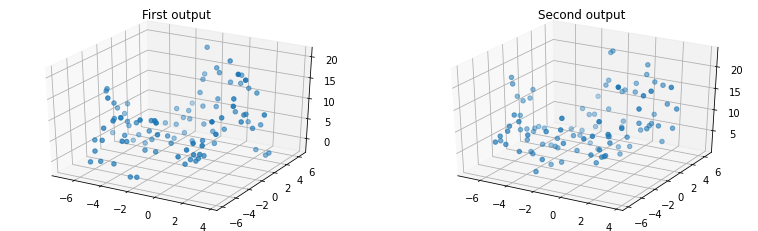

In [11]:
# Generate 3D TSNE plots for both outputs
def plot_3d(X, y, y_pred=None):
  X_tnse = TSNE(n_components=2, random_state=123).fit_transform(X)
  fig = plt.figure(figsize=plt.figaspect(0.3))
  
  # plot the first output y[:,0]
  ax = fig.add_subplot(1, 2, 1, projection='3d')
  ax.scatter(X_tnse[:,0], X_tnse[:,1], y[:,0], label='y_true')
  ax.set_title("First output")
  if y_pred is not None:
    ax.scatter(X_tnse[:,0], X_tnse[:,1], y_pred[:,0], label='y_pred', marker='v')
  
  # plot the second output y[:,1]
  ax = fig.add_subplot(1, 2, 2, projection='3d')
  ax.scatter(X_tnse[:,0], X_tnse[:,1], y[:,1], label='y_true')
  ax.set_title("Second output")
  if y_pred is not None:
    ax.scatter(X_tnse[:,0], X_tnse[:,1], y_pred[:,1], label='y_pred', marker='v')
  
plot_3d(x, y_true)

# Define a loss function
MSE

In [12]:
# Loss Function with gradient descent
class MSE:
  def __init__(self, y_pred, y_true):
    self.y_pred = y_pred
    self.y_true = y_true

  def loss(self):
    n = self.y_true.shape[0]
    return ((self.y_pred - self.y_true) ** 2) / n
    
  def backward(self):
    n = self.y_true.shape[0]
    self.gradient = 2 * (self.y_pred - self.y_true) / n
    return self.gradient

# Define activation functions
Relu for auto diffentiation

In [13]:
# RELU non-linear layer class
class Relu:
  def __init__(self):
    self.input_ = tf.constant([])

  def forward(self, input_):
    self.input_  = input_
    self.output_ = tf.clip_by_value(self.input_, clip_value_min=0, clip_value_max=tf.float32.max) 
    return self.output_
    
  def backward(self):
    return 
    
  def update(self, lr):
    return


# Define backpropagation with autograd for Linear, Relu layers

In [14]:
# Layer class with backpropagation 
# Default activation is linear, pass in activation='relu' for non-linear
class Layer:
  # Init
  def __init__(self, ni=1, no=1, activation='Linear'):
    self.ni = ni
    self.no = no
    self.activation = 'Linear'

    # Init
    r1 = -1
    r2 = 1
    self.weights = tf.Variable(tf.random.uniform((ni, no), r1, r2))
    self.bias = tf.Variable(tf.random.uniform((1, 1), r1, r2))
    self.x = tf.zeros([ni])
    
    # activation
    if activation == 'Relu':
      self.activation = Relu()
  
  # Forward propagate input, output, weights, bias gradient
  def forward(self, x):
    self.x = x
    self.output = tf.matmul(x, self.weights) + tf.transpose(self.bias)

   # Pass output to activation function
    if self.activation != 'Linear':
      return self.activation.forward(self.output)
    else:
      return self.output 
  
  # Backpropagate gradients, upstream gradient not required
  def backward(self, weights_gradient, bias_gradient):
    self.weights_gradient = weights_gradient
    self.bias_gradient = bias_gradient

  # Update weights, bias
  def update(self, lr):
    self.weights = tf.Variable(self.weights - lr * self.weights_gradient)
    self.bias = tf.Variable(self.bias - lr * self.bias_gradient)

  # Print the layer params
  def dump(self):
    print('Layer has ni', self.ni)
    print('Layer has no', self.no)
    print('Layer has activation function', self.activation)
    print('Layer has weights', self.weights)
    print('Layer has bias', self.bias)

# Build the nueral net

In [18]:
# High level NN class
class Model:
  # Dump NN
  def dump(self):
    print('Builiding NN:')
    for j, layer in enumerate(self.layers):
      print('---- Layer {} ----'.format(j))
      layer.dump()
    
  # Init
  def __init__(self, ni=3, nh=[2], no=2, activation='Linear'):
    self.ni = ni
    self.nh = nh
    self.no = no
     
    # Build a chain of layers to form the NN
    self.layers = []
    self.layers.append(Layer(ni, no, activation='Linear'))
    self.layers.append(Layer(no, 5, activation))
    self.layers.append(Layer(5, 2, activation))
        
  # Dump the model created
    self.dump()
    
  # Forward propagate
  def forward(self, inputs):
    o = inputs
    for l in self.layers:
      o = l.forward(o)
    return o

  # Back propagate loss, gradients
  def backward(self, y_pred, y_true, tape):
    mse = MSE(y_pred, y_true)
    for layer in reversed(self.layers):
      [weights_gradient, bias_gradient] = tape.gradient(mse.loss(), [layer.weights, layer.bias])
      layer.backward(weights_gradient, bias_gradient)
  
  # Update lr
  def update(self, lr):
    for layer in self.layers:
      layer.update(lr)
  
  # Train model
  def fit(self, x, y_true, lr, epochs):
    print('Propagating input: ' + str(x[:2]))
    for epoch in range(epochs):
      with tf.GradientTape(persistent=True) as tape:
       y_pred = self.forward(x)
       self.backward(y_pred, y_true, tape)
      self.update(lr)

# Train neural net with non-linear relu layer

In [19]:
# Configure hyperparams of model
num_epochs = 40
lr = 0.01
ni = x.shape[1]
no = y_true.shape[1]
nh = [5,3]

In [25]:
nn = Model(ni, nh, no=no, activation='Relu')
nn.fit(x, y_true, lr, num_epochs)
y_pred = nn.forward(x)

loss = mean_squared_error(y_true, y_pred)
print('Final Loss is ', loss)

Builiding NN:
---- Layer 0 ----
Layer has ni 3
Layer has no 2
Layer has activation function Linear
Layer has weights <tf.Variable 'Variable:0' shape=(3, 2) dtype=float32, numpy=
array([[-0.5707238 ,  0.8217101 ],
       [ 0.13066673,  0.3705516 ],
       [ 0.15633821, -0.3995061 ]], dtype=float32)>
Layer has bias <tf.Variable 'Variable:0' shape=(1, 1) dtype=float32, numpy=array([[0.3827083]], dtype=float32)>
---- Layer 1 ----
Layer has ni 2
Layer has no 5
Layer has activation function <__main__.Relu object at 0x7f2067389f10>
Layer has weights <tf.Variable 'Variable:0' shape=(2, 5) dtype=float32, numpy=
array([[ 0.20929527,  0.15763688, -0.22422147, -0.1442821 ,  0.12548852],
       [ 0.28815436, -0.5476644 , -0.6663809 ,  0.01554441,  0.1589253 ]],
      dtype=float32)>
Layer has bias <tf.Variable 'Variable:0' shape=(1, 1) dtype=float32, numpy=array([[-0.2294333]], dtype=float32)>
---- Layer 2 ----
Layer has ni 5
Layer has no 2
Layer has activation function <__main__.Relu object at 0x7

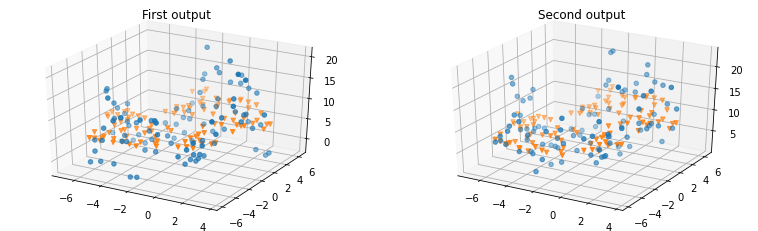

In [26]:
plot_3d(x, y_true, y_pred)

# Train neural net with only linear layers

In [22]:
nn = Model(ni, nh, no=no, activation='Linear')
nn.fit(x, y_true, lr, num_epochs)
y_pred = nn.forward(x)

loss = mean_squared_error(y_true, y_pred)
print('Final Loss is ', loss)

Builiding NN:
---- Layer 0 ----
Layer has ni 3
Layer has no 2
Layer has activation function Linear
Layer has weights <tf.Variable 'Variable:0' shape=(3, 2) dtype=float32, numpy=
array([[-0.132267  , -0.4658594 ],
       [ 0.19235492,  0.8094232 ],
       [-0.6982646 , -0.41629958]], dtype=float32)>
Layer has bias <tf.Variable 'Variable:0' shape=(1, 1) dtype=float32, numpy=array([[0.37683296]], dtype=float32)>
---- Layer 1 ----
Layer has ni 2
Layer has no 5
Layer has activation function Linear
Layer has weights <tf.Variable 'Variable:0' shape=(2, 5) dtype=float32, numpy=
array([[ 0.99272966,  0.49512053, -0.5327847 , -0.75218344,  0.4998374 ],
       [ 0.5641444 , -0.74175143, -0.16498232, -0.46723843, -0.9354994 ]],
      dtype=float32)>
Layer has bias <tf.Variable 'Variable:0' shape=(1, 1) dtype=float32, numpy=array([[-0.02878261]], dtype=float32)>
---- Layer 2 ----
Layer has ni 5
Layer has no 2
Layer has activation function Linear
Layer has weights <tf.Variable 'Variable:0' shape=(5,

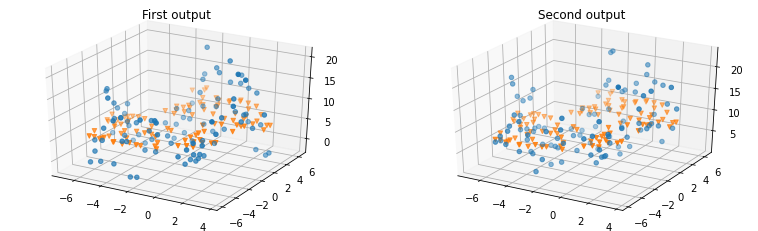

In [23]:
plot_3d(x, y_true, y_pred)